In [1]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from fuzzywuzzy import process

%matplotlib inline
sns.set(color_codes=True)

In [2]:
df = pd.read_csv('../data/claims_sample_data.csv')
print(df.dtypes)
print(df.info)

MONTH                int64
SERVICE_CATEGORY    object
CLAIM_SPECIALTY     object
PAYER               object
PAID_AMOUNT          int64
dtype: object
<bound method DataFrame.info of         MONTH SERVICE_CATEGORY     CLAIM_SPECIALTY    PAYER  PAID_AMOUNT
0      201801     AncillaryFFS                 NaN  Payer F         4281
1      201801     AncillaryFFS                 NaN  Payer H         2221
2      201801     AncillaryFFS                 NaN  Payer O         3937
3      201801     AncillaryFFS                 NaN  Payer W          268
4      201801     AncillaryFFS                 ACH  Payer W          151
...       ...              ...                 ...      ...          ...
52147  202007   SpecialistsFFS  RADIATION ONCOLOGY  Payer F          869
52148  202007   SpecialistsFFS    REGISTERED NURSE  Payer H           99
52149  202007   SpecialistsFFS        RHEUMATOLOGY  Payer F          536
52150  202007   SpecialistsFFS    SPECIAL SERVICES  Payer H         1064
52151  202007   

## Чистка данных

In [3]:
# Поиск дублей
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows:", duplicate_rows_df.shape)

number of duplicate rows: (0, 5)


In [4]:
df.isnull().sum()

MONTH                 0
SERVICE_CATEGORY      0
CLAIM_SPECIALTY     251
PAYER                 0
PAID_AMOUNT           0
dtype: int64

In [7]:
MATCH_RATIO = 94
MIN_WORD_LEN = 6

def find_substrings(vals: set) -> dict:
    vals = sorted(vals)
    match_map = {}
    for index, val in enumerate(vals[:-1]):
        for next_index in range(index + 1, len(vals)):
            if vals[next_index].find(val, 0, len(val)) < 0:
                break
            if vals[next_index][len(val)] == ' ':
                continue
            if match_map.get(val) and len(match_map.get(val)) <= len(vals[next_index]):
                continue
            match_map[val] = vals[next_index]
    for val in list(set(match_map.keys()) & set(match_map.values())):
        match_map.pop(val)
    return match_map


def match_rows(vals: set) -> dict:
    results = {}
    vals = sorted(list(filter(lambda x: len(x) >= MIN_WORD_LEN, vals)))
    for val in vals:
        res = process.extract(val, vals, limit=4)
        results[val] = res[1:]
    substr_map = {}
    for val in vals:
        if val in substr_map.keys():
            continue
        similar_combinations = results.get(val, [])
        for similar_comb, ratio in similar_combinations:
            if ratio <= MATCH_RATIO:
                continue
            substr_map[similar_comb] = val
    return substr_map


Нулевые значения платежей посчитаем незначащими.

In [8]:
df3 = df.loc[df['PAID_AMOUNT'] == 0]
df3.shape

(3847, 5)

In [9]:
df = df.loc[df['PAID_AMOUNT'] != 0]
df['MONTH_DT'] = pd.to_datetime(df['MONTH'], format='%Y%m', errors='coerce').dt.date
df = df.dropna()
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].str.upper().str.strip()
for item in ['(', ')', '-', '/', '\\', ',', 'AND', '&', '\'S', '.']:
    df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].str.replace(item, ' ', regex=True)
df['CLAIM_SPECIALTY_SPLIT'] = df['CLAIM_SPECIALTY'].apply(lambda x: str(x).split())
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY_SPLIT'].apply(lambda x: ' '.join(sorted(set(x), key=x.index)))
del df['CLAIM_SPECIALTY_SPLIT']
df['SERVICE_CATEGORY'] = df['SERVICE_CATEGORY'].replace('SpecialistFFS', 'SpecialistsFFS')
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].replace({'SURGICAL': 'SURGERY', 'ORTHOPAEDIC': 'ORTHOPEDIC'}, regex=True)
m_map = match_rows(set(df['CLAIM_SPECIALTY'].tolist()))
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].replace(m_map)
s_map = find_substrings(set(df['CLAIM_SPECIALTY'].tolist()))
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].replace(s_map)


Отрицательные значения платежей считать выбросами\ошибками?
Распределены они не равномерно, встречаются только у 2х категорий сервисов, при этом уводят сумму платежей за весь период по отделению PCPEncounter в отрицательное значение.

In [10]:
df3 = df.loc[df['PAID_AMOUNT'] < 0]
df_negative_p_sc = df3[['SERVICE_CATEGORY', 'PAID_AMOUNT']].groupby('SERVICE_CATEGORY').count()
print(df_negative_p_sc)
df_negative_p_p = df3[['PAYER', 'PAID_AMOUNT']].groupby('PAYER').count()
print(df_negative_p_p)
df2 = df[['SERVICE_CATEGORY', 'PAID_AMOUNT']].groupby('SERVICE_CATEGORY').sum()
print(df2)

                  PAID_AMOUNT
SERVICE_CATEGORY             
AncillaryFFS              236
PCPEncounter               82
          PAID_AMOUNT
PAYER                
Payer B             6
Payer CA           83
Payer CO            1
Payer H             3
Payer UN          223
Payer W             2
                    PAID_AMOUNT
SERVICE_CATEGORY               
ASCServices             5182525
AncillaryFFS           19009539
ERServices             11742674
InpatientServices      87799436
OutpatientServices     22913612
PCPEncounter             -35888
PCPFFS                  3684644
SNFServices             8147959
SpecialistsFFS         34294315


In [11]:
# Отрицательные значения тоже исключим
df = df.loc[df['PAID_AMOUNT'] > 0]
df.shape

(47727, 6)

## Разброс платежей, в том числе в группах по отделениям и страховым компаниям

<Axes: xlabel='PAID_AMOUNT'>

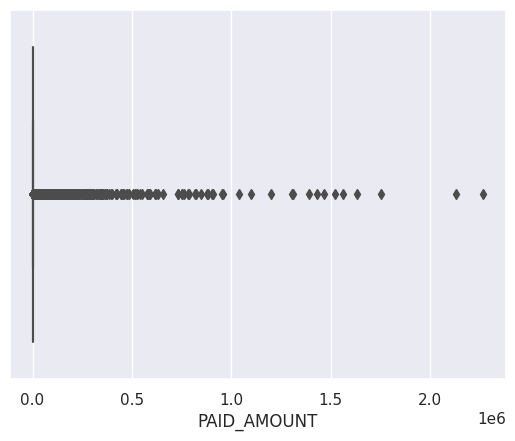

In [12]:
sns.boxplot(x=df['PAID_AMOUNT'])

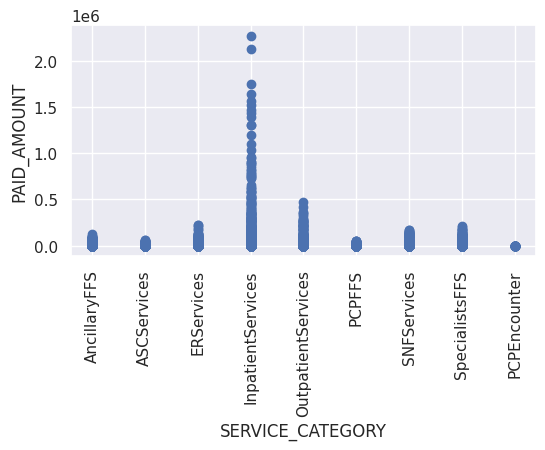

In [13]:
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(df['SERVICE_CATEGORY'], df['PAID_AMOUNT'])
ax.set_xlabel('SERVICE_CATEGORY')
ax.set_ylabel('PAID_AMOUNT')
plt.xticks(rotation=90)
plt.show()

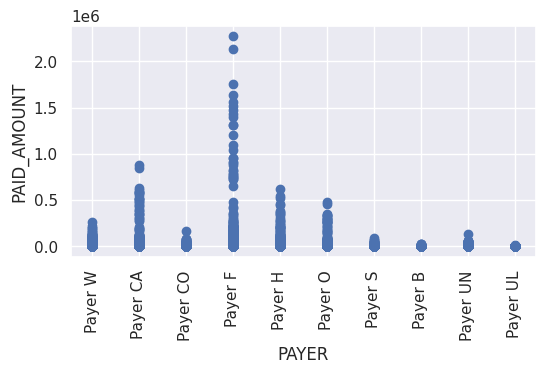

In [14]:
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(df['PAYER'], df['PAID_AMOUNT'])
ax.set_xlabel('PAYER')
ax.set_ylabel('PAID_AMOUNT')
plt.xticks(rotation=90)
plt.show()

## Суммы платежей в разрезах за весь период

                    PAID_AMOUNT
SERVICE_CATEGORY               
PCPEncounter              18353
PCPFFS                  3684644
ASCServices             5182525
SNFServices             8147959
ERServices             11742674
AncillaryFFS           19296630
OutpatientServices     22913612
SpecialistsFFS         34294315
InpatientServices      87799436


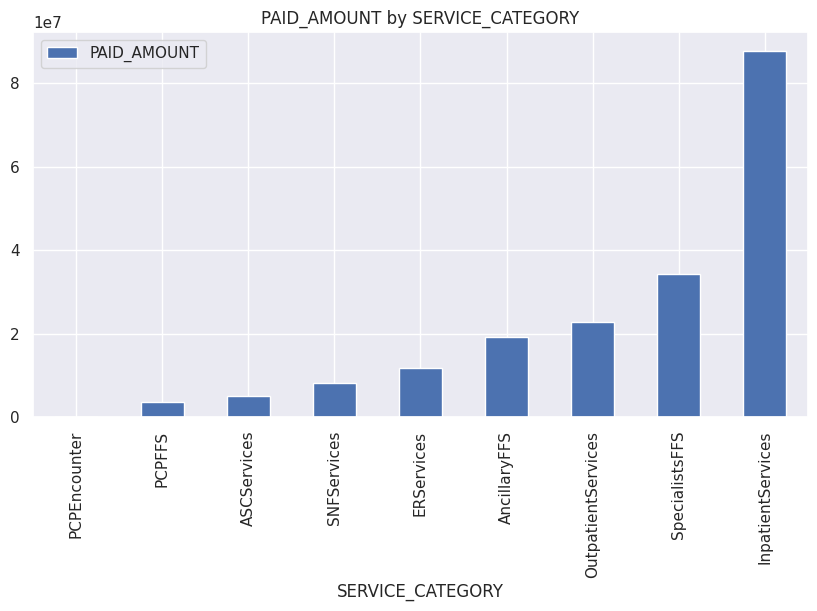

In [15]:
df2 = df[['SERVICE_CATEGORY', 'PAID_AMOUNT']].groupby('SERVICE_CATEGORY').sum().sort_values(by=['PAID_AMOUNT'])
df2.plot(kind='bar', figsize=(10,5))
plt.title("PAID_AMOUNT by SERVICE_CATEGORY")
print(df2)

Максимальные затраты приходятся на категории InpatientServices, SpecialistsFFS, OutpatientServices.
Минимальные - на PCPEncounter, PCPFFS.

     SERVICE_CATEGORY       SUM  COUNT          AVG
0        PCPEncounter     18353     43   426.813953
1         ASCServices   5182525   2548  2033.958006
2        AncillaryFFS  19296630   8090  2385.244747
3      SpecialistsFFS  34294315  13375  2564.060935
4              PCPFFS   3684644   1367  2695.423555
5  OutpatientServices  22913612   7303  3137.561550
6          ERServices  11742674   3493  3361.773261
7         SNFServices   8147959   2315  3519.636717
8   InpatientServices  87799436   9193  9550.683781


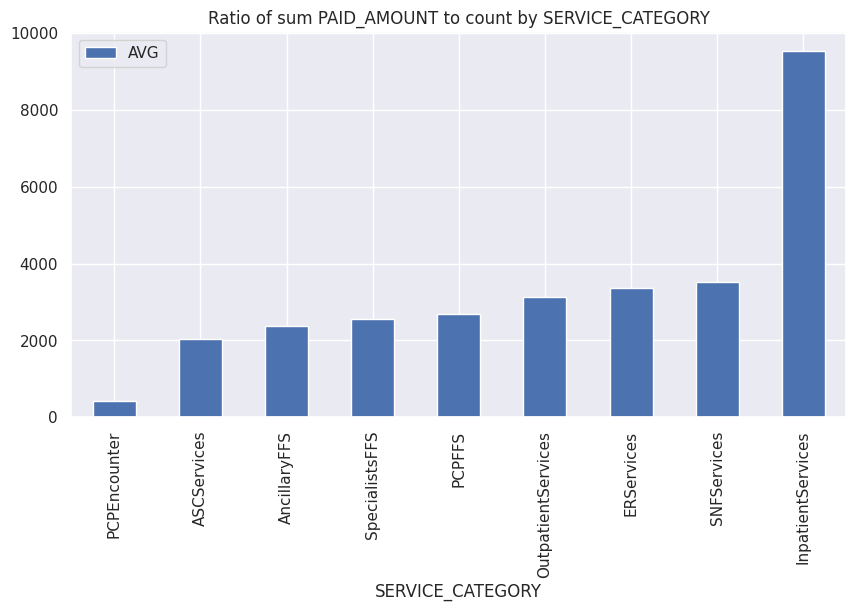

In [16]:
df2 = df.groupby('SERVICE_CATEGORY')['PAID_AMOUNT'].agg(SUM='sum', COUNT='count')
df2['AVG'] = df2['SUM'].div(df2['COUNT'])
df2 = df2.sort_values(by=['AVG']).reset_index()
df2[['SERVICE_CATEGORY', 'AVG']].plot(kind='bar', figsize=(10,5), x='SERVICE_CATEGORY', y='AVG')
plt.title('Ratio of sum PAID_AMOUNT to count by SERVICE_CATEGORY')
print(df2)

По средней величине платежа в топе уже InpatientServices, SNFServices, ERServices

          PAID_AMOUNT
PAYER                
Payer UL       310027
Payer B       2409074
Payer S       3784945
Payer CO      5068766
Payer UN      6272206
Payer W      12180796
Payer O      21261058
Payer H      21768803
Payer CA     33690508
Payer F      86333965


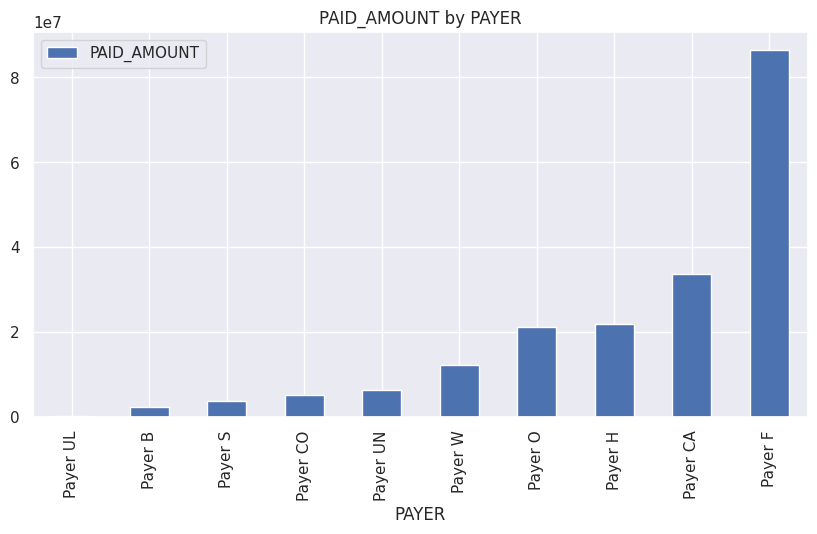

In [17]:
df2 = df[['PAYER', 'PAID_AMOUNT']].groupby('PAYER').sum().sort_values(by=['PAID_AMOUNT'])
df2.plot(kind='bar', figsize=(10,5))
plt.title("PAID_AMOUNT by PAYER")
print(df2)

Максимальные затраты приходятся на страховые компании F, CA, H, O.
Минимальные - на UL, B, S.

      PAYER       SUM  COUNT          AVG
0  Payer UL    310027    562   551.649466
1   Payer B   2409074   3206   751.426700
2   Payer S   3784945   3877   976.256126
3  Payer UN   6272206   4898  1280.564720
4  Payer CO   5068766   3673  1380.007079
5   Payer W  12180796   6595  1846.974375
6   Payer O  21261058   6094  3488.851001
7  Payer CA  33690508   7851  4291.237804
8   Payer H  21768803   2235  9739.956600
9   Payer F  86333965   8736  9882.550939


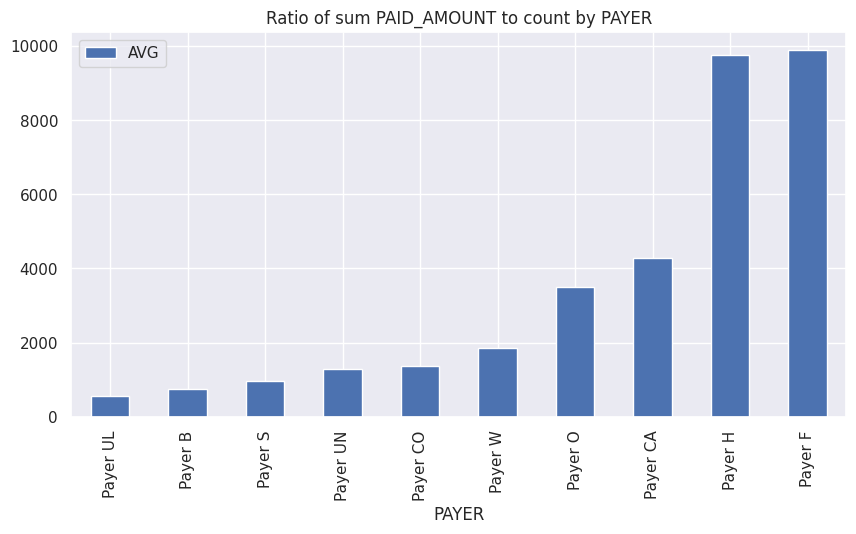

In [18]:
df2 = df.groupby('PAYER')['PAID_AMOUNT'].agg(SUM='sum', COUNT='count')
df2['AVG'] = df2['SUM'].div(df2['COUNT'])
df2 = df2.sort_values(by=['AVG']).reset_index()
df2[['PAYER', 'AVG']].plot(kind='bar', figsize=(10,5), x='PAYER', y='AVG')
plt.title('Ratio of sum PAID_AMOUNT to count by PAYER')
print(df2)

По средней величине платежа в разрезе страхователей аналогично.

In [19]:
df2 = df[['CLAIM_SPECIALTY', 'PAID_AMOUNT']].groupby('CLAIM_SPECIALTY').sum().sort_values(by=['PAID_AMOUNT'], ascending=False)
print('Топ-10 самых затратных услуг')
print(df2.head(10))

Топ-10 самых затратных услуг
                                          PAID_AMOUNT
CLAIM_SPECIALTY                                      
INP                                          41412982
HOSPITAL                                     40113868
OUTPATIENT MENTAL HEALTH CLINICIAN GROUP     14025004
HEMATOLOGY ONCOLOGY                           6111451
INTERNAL MEDICINE                             4860165
MEDICAL DOCTOR                                4555419
CARDIOLOGY                                    4409537
SNF                                           4248390
RADIOLOGY                                     3207034
SKILLED NURSING FACILITY                      2719775


## Графики по месяцам

### Попробуем отследить временные тренды в разрезе категорий сервисов

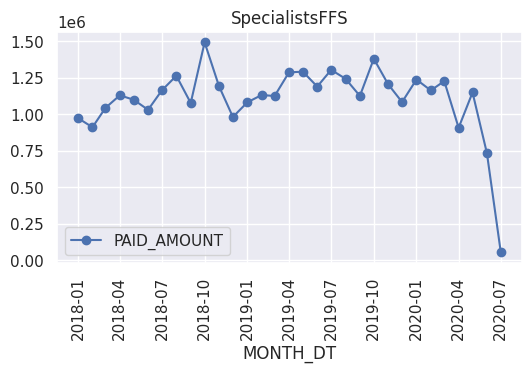

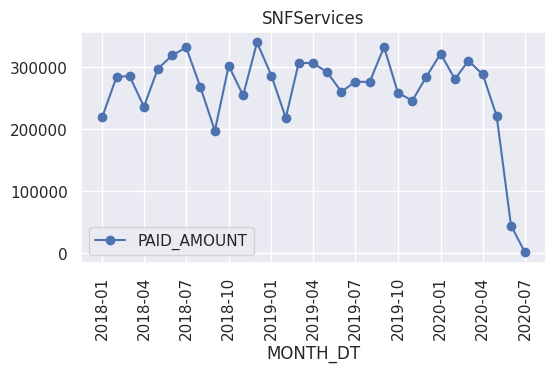

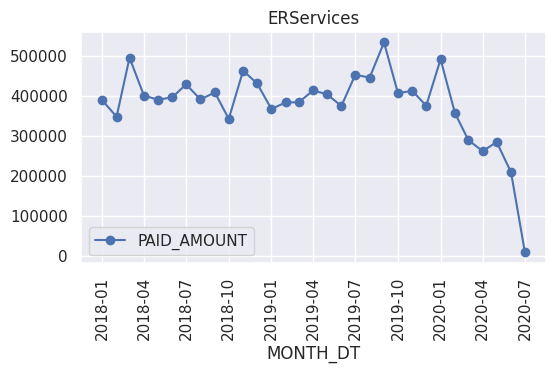

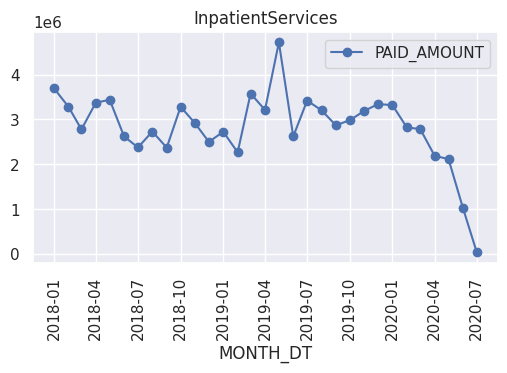

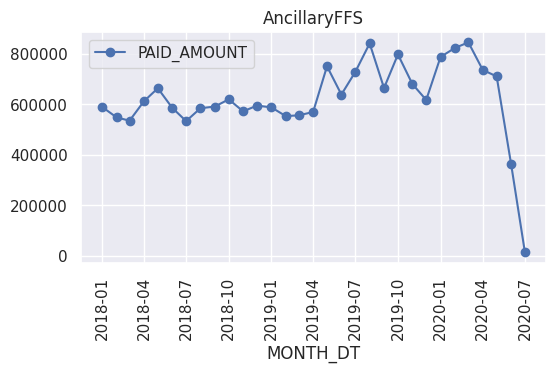

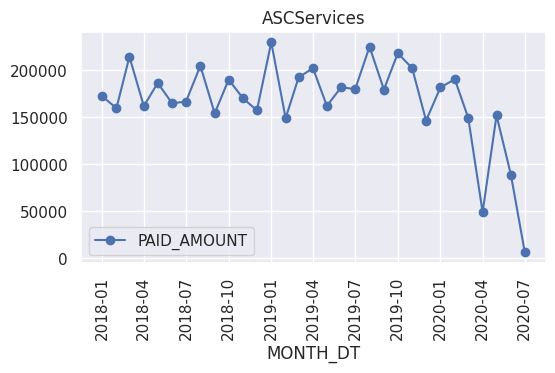

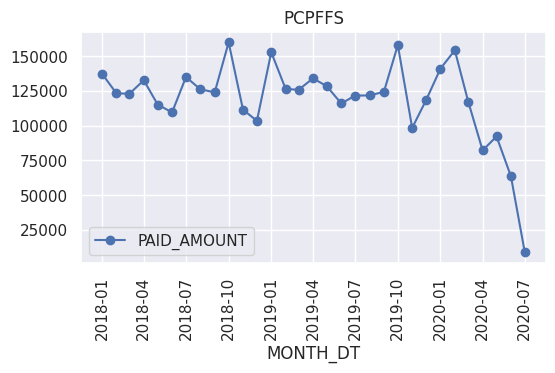

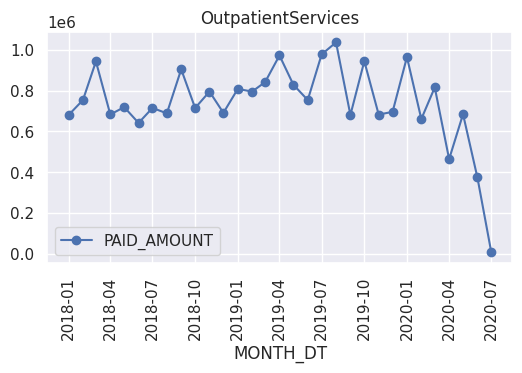

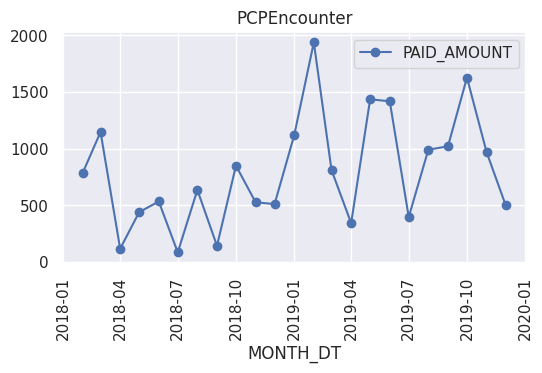

In [20]:
sc_list = set(df['SERVICE_CATEGORY'].to_list())
for sc in sc_list:
    df_part = df.loc[df['SERVICE_CATEGORY'] == sc]
    df_part_groped = df_part[['MONTH_DT', 'PAID_AMOUNT']].groupby('MONTH_DT').sum().reset_index()
    df_part_groped.plot(x='MONTH_DT', y='PAID_AMOUNT', rot=90, figsize=(6, 3), grid=True, marker='o', title=sc)

Заметно снижение суммарных затрат за месяц по многим категориям сервисов к концу периода, как и количество выплат.

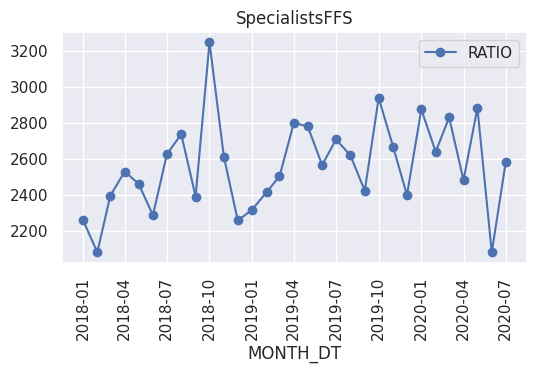

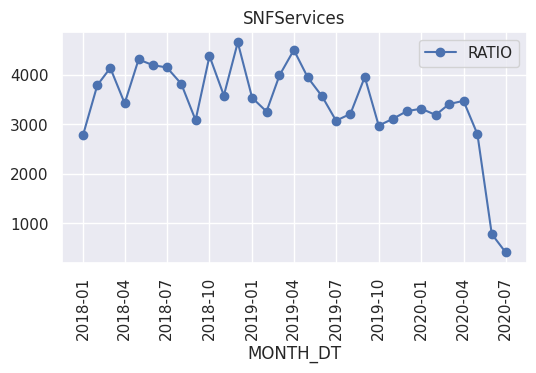

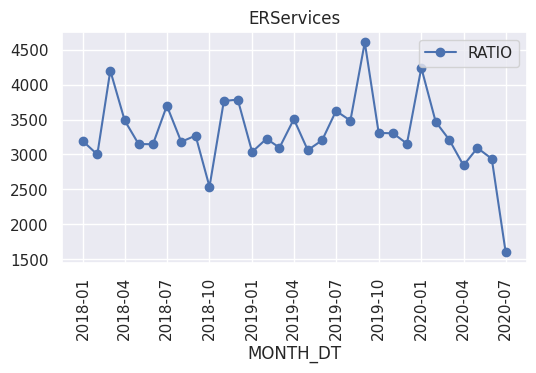

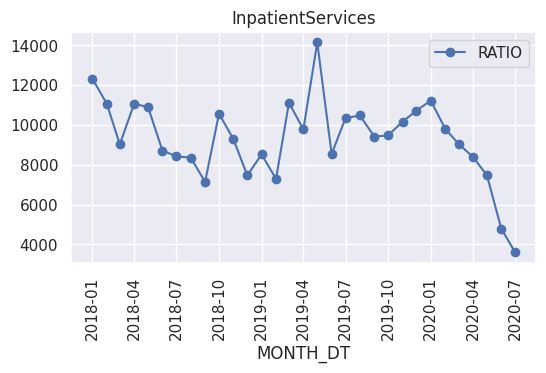

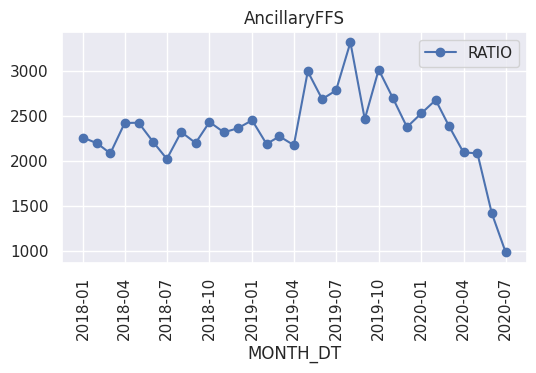

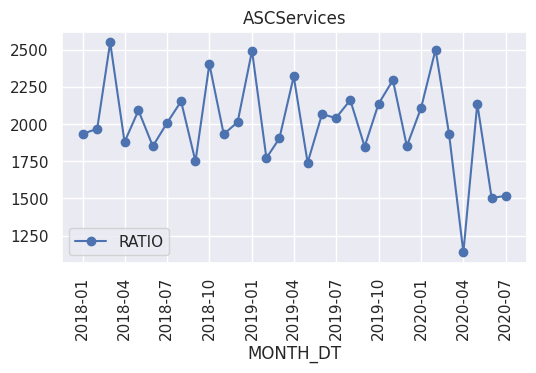

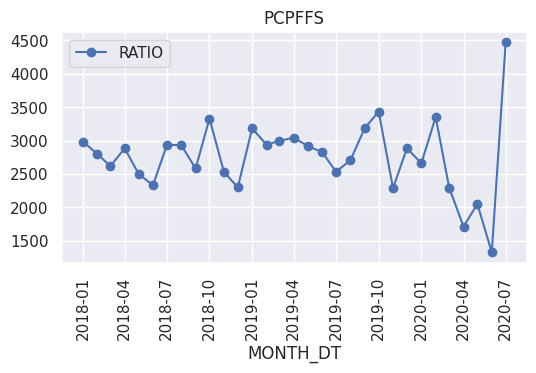

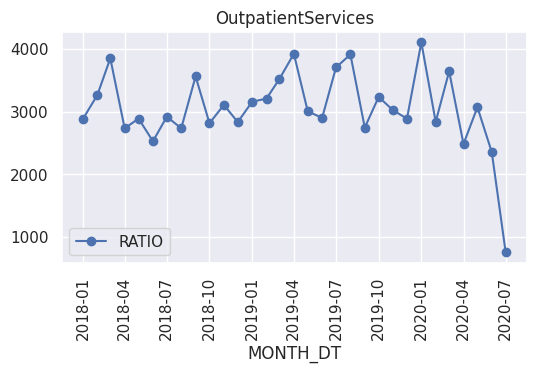

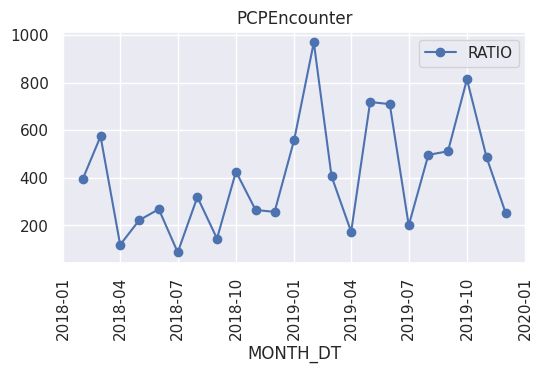

In [21]:
sc_list = set(df['SERVICE_CATEGORY'].to_list())
for sc in sc_list:
    df_part = df.loc[df['SERVICE_CATEGORY'] == sc]
    df_part_groped = df_part.groupby('MONTH_DT')['PAID_AMOUNT'].agg(SUM='sum', COUNT='count').reset_index()
    df_part_groped['RATIO'] = df_part_groped['SUM'].div(df_part_groped['COUNT'])
    df_part_groped.plot(x='MONTH_DT', y='RATIO', rot=90, figsize=(6, 3), grid=True, marker='o', title=sc)



### Попробуем отследить временные тренды в разрезе страховых компаний

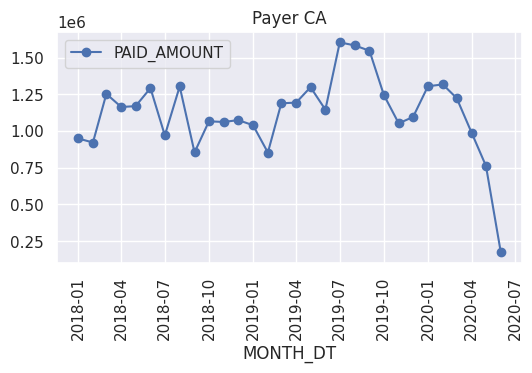

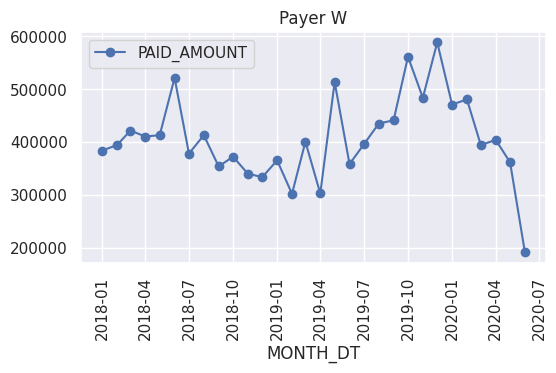

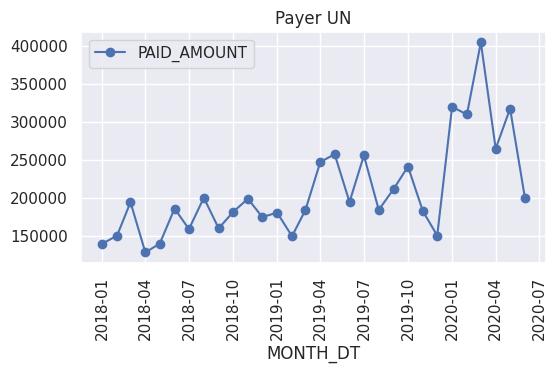

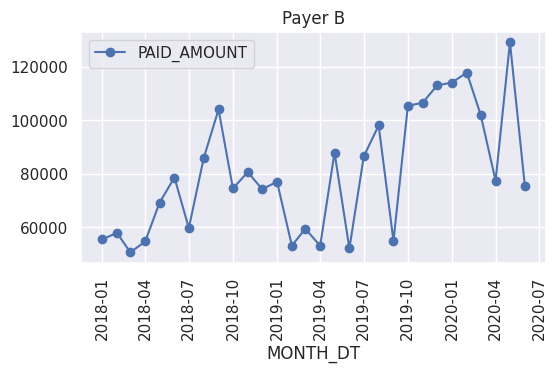

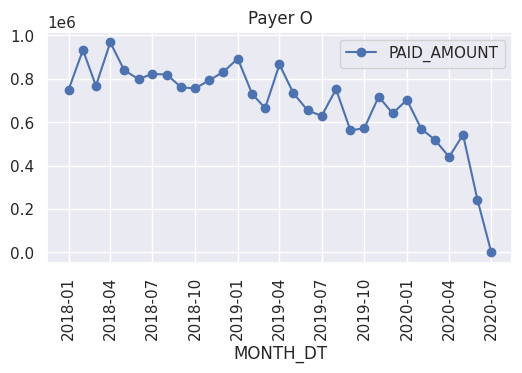

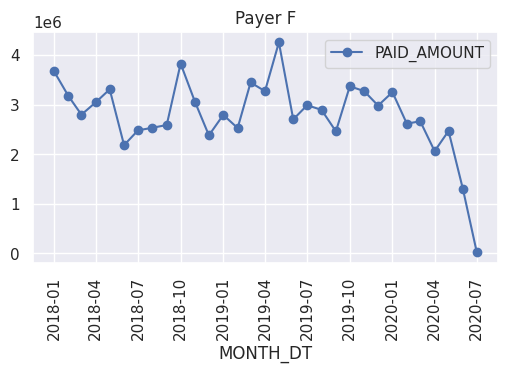

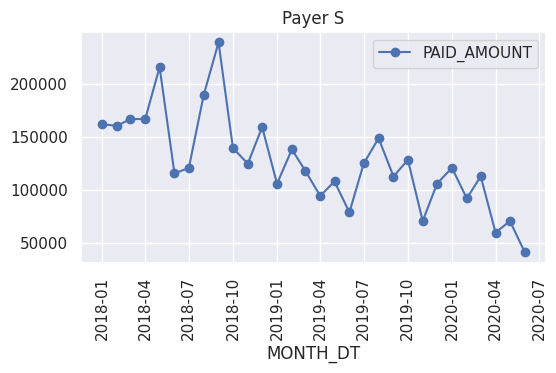

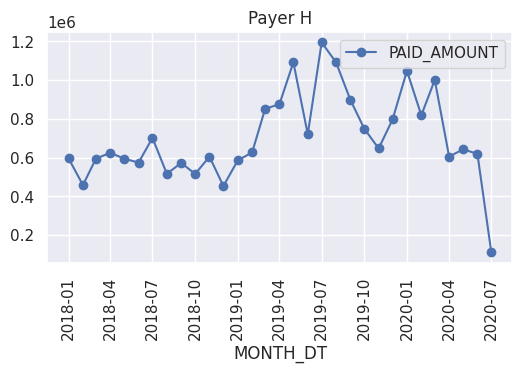

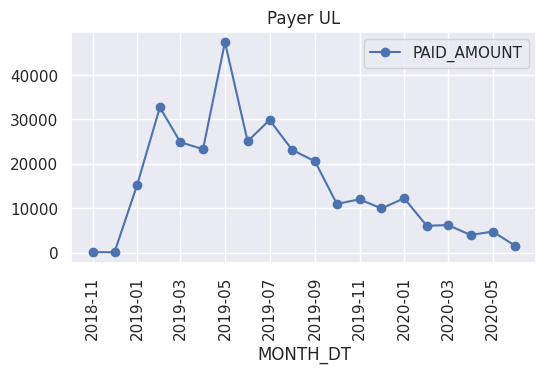

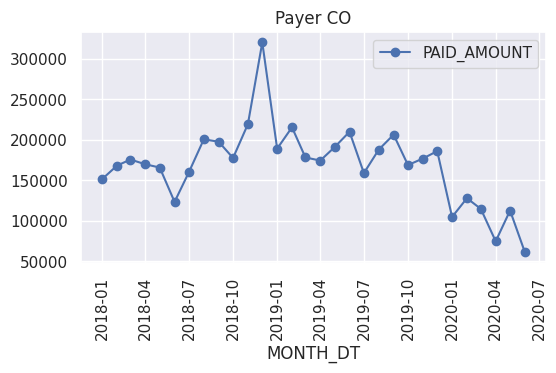

In [22]:
sc_list = set(df['PAYER'].to_list())
for sc in sc_list:
    df_part = df.loc[df['PAYER'] == sc]
    df_part_groped = df_part[['MONTH_DT', 'PAID_AMOUNT']].groupby('MONTH_DT').sum().reset_index()
    df_part_groped.plot(x='MONTH_DT', y='PAID_AMOUNT', rot=90, figsize=(6, 3), grid=True, marker='o', title=sc)

Заметно снижение затрат у страховых компаний S, O на протяжении всего периода, у других компаний (UL, CO) снижение наметилось с середины 2019 года.
У компании UN напротив наблюдается тенденция роста затрат. W, H - в конце 2019\начале 2020 преодолели пик.

### Попробуем отследить временные тренды в разрезе сервисов

Групп довольно много, поэтому сохраним графики в файлы.

In [246]:
# path = '../images/charts_by_specialty_sum'
# fig, ax = plt.subplots(figsize=(10,6))
# specialties = set(df['CLAIM_SPECIALTY'].to_list())
# for specialty in list(specialties):
#     df_part = df.loc[df['CLAIM_SPECIALTY'] == specialty]
#     df_part_sum = df_part[['MONTH_DT', 'PAID_AMOUNT']].groupby('MONTH_DT').sum()
#     df_part_sum = df_part_sum.reset_index()
#     ax.plot(df_part_sum['MONTH_DT'], df_part_sum['PAID_AMOUNT'])
#     ax.scatter(df_part_sum['MONTH_DT'], df_part_sum['PAID_AMOUNT'])
#     ax.set_xlabel('MONTH_DT')
#     ax.set_ylabel('PAID_AMOUNT')
#     plt.xticks(rotation=45)
#     plt.title(specialty)
#     figname = 'fig_{}.png'.format(specialty.replace('/', ' '))
#     dest = os.path.join(path, figname)
#     # plt.show()
#     plt.savefig(dest)  # write image to file
#     plt.cla()
# plt.close(fig)
# print('Done.')

Done.


In [23]:
GRAPH_LIMIT = 20
def show_graph(specialties):
    for sp_name in specialties[:GRAPH_LIMIT]:
        df_p = df.loc[df['CLAIM_SPECIALTY'] == sp_name]
        df_p_sum = df_p[['MONTH_DT', 'PAID_AMOUNT']].groupby('MONTH_DT').sum()
        df_p_sum = df_p_sum.reset_index()
        figure, ax = plt.subplots(figsize=(6,3))
        ax.plot(df_p_sum['MONTH_DT'], df_p_sum['PAID_AMOUNT'])
        ax.scatter(df_p_sum['MONTH_DT'], df_p_sum['PAID_AMOUNT'])
        plt.xticks(rotation=45)
        plt.title(sp_name)
        plt.show()

Выводы по этой части удобней смотреть на дашборде.

Можно заметить повышение затрат по сервису ADVANCED REGISTERED NURSE PRACTITIONER с середины 2019 года.


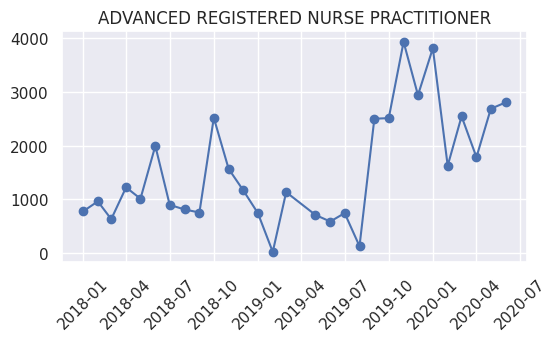

In [24]:
show_graph(['ADVANCED REGISTERED NURSE PRACTITIONER'])


Заметно снижение затрат по медицинской услуге AMBULANCE (и всех смежных), ANESTHESIOLOGY, HOSPITAL, EMERGENCY MEDICINE, INTERNAL MEDICINE
 c начала 2020 года.

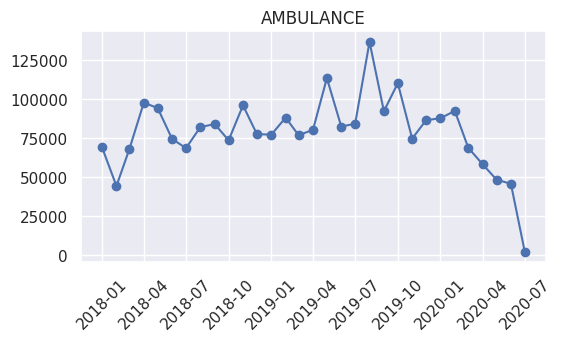

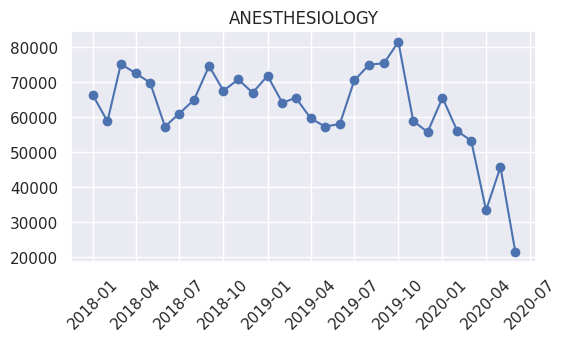

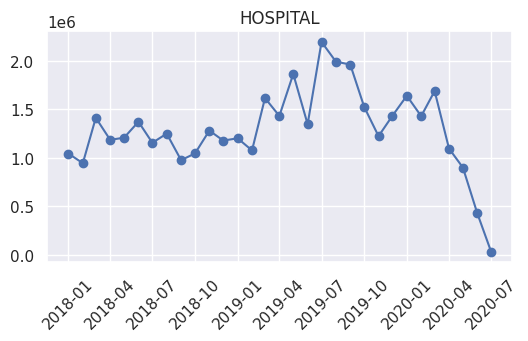

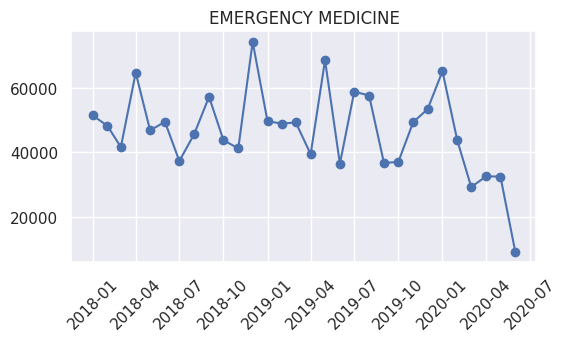

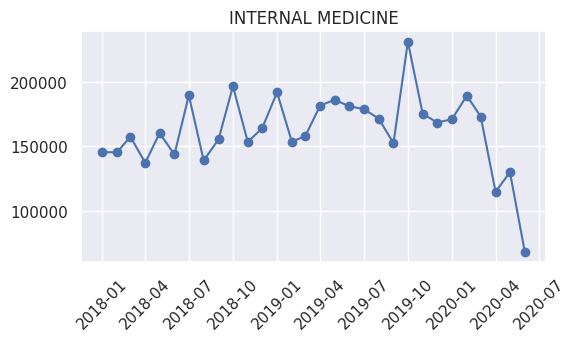

In [25]:
show_graph(['AMBULANCE', 'ANESTHESIOLOGY', 'HOSPITAL', 'EMERGENCY MEDICINE', 'INTERNAL MEDICINE'])


На всем периоде заметно стабильное повышение затрат в категории ONCOLOGY.


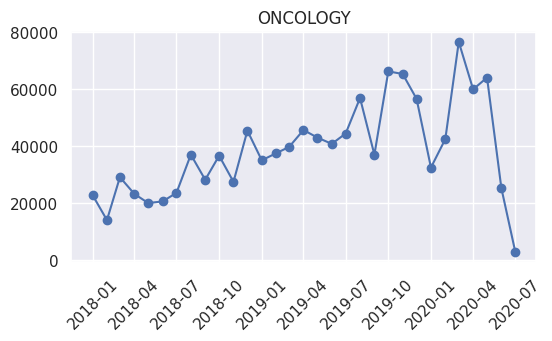

In [26]:
show_graph(['ONCOLOGY'])

На всем периоде наблюдается снижение затрат по FAMILY PRACTICE, FITNESS, GASTROENTEROLOGY, GERIATRICS, GYNECOLOGY, OPHTHALMOLOGY,
и для сервиса OUTPATIENT MENTAL HEALTH CLINICIAN GROUP с середины 2019 года.


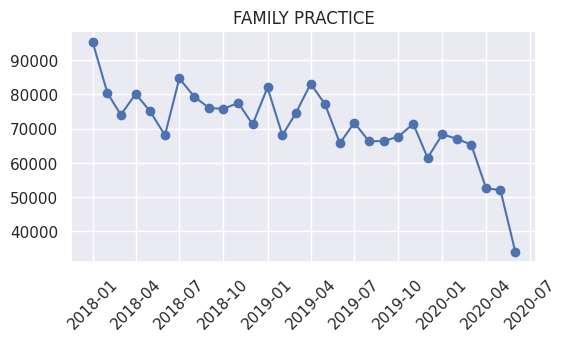

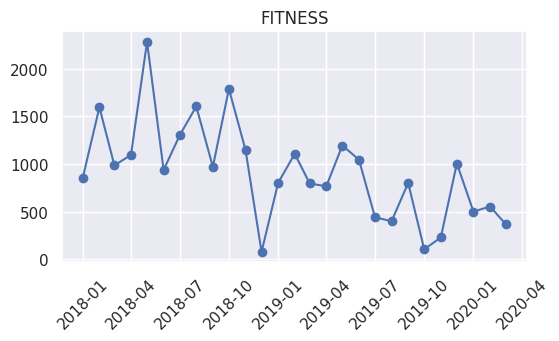

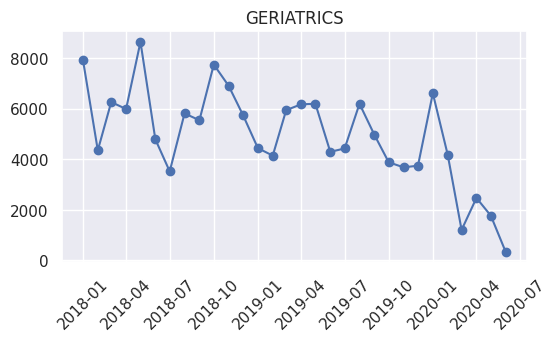

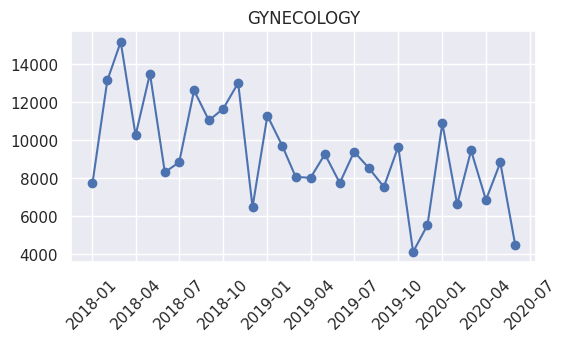

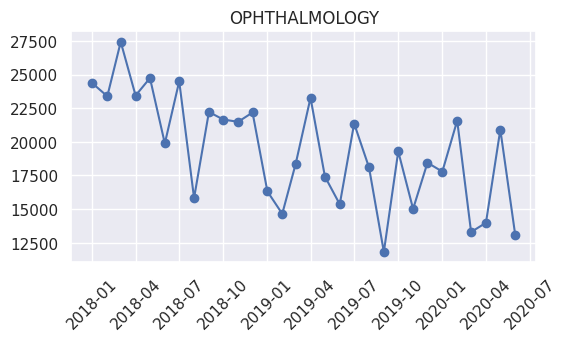

In [27]:
show_graph(['FAMILY PRACTICE', 'FITNESS', 'GERIATRICS', 'GYNECOLOGY', 'OPHTHALMOLOGY'])